In [ ]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy.spatial.distance import cdist
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# 1. Read data

In [5]:
listings = pd.read_csv('data/02_intermediate/listings_prep.csv')

C:\Users\2702471O\AppData\Local\Temp\ipykernel_20292\1421078732.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  listings = pd.read_csv('data/02_intermediate/listings_prep.csv')


In [ ]:
EPC_dfs = []

for chunk in pd.read_csv('data/02_intermediate/epc.csv.gz', chunksize=10000):
    EPC_dfs.append(chunk)

epcs = pd.concat(EPC_dfs)

In [7]:
# 2011 Census
dir = 'data/01_raw/NSPL'

geos = os.listdir(dir)

dfs = []

# load files
for geo in geos:
    path = dir + '\\' + geo

    for chunk in pd.read_csv(path, chunksize=10000):
        dfs.append(chunk)

geo_lookup = pd.concat(dfs)

# 2. Data linkage

In [8]:
listing_epc = listings.join(epcs.set_index('UPRN'), on='uprn', how='inner')

In [9]:
listing_epc['listing_id'].nunique()

226291

# 3. Deduplication

In [12]:
listing_epc['date'] = pd.to_datetime(listing_epc['date'],format='%Y-%m-%d')
listing_epc['LODGEMENT_DATE'] = pd.to_datetime(listing_epc['LODGEMENT_DATE'],format='%Y-%m-%d')
listing_epc['INSPECTION_DATE'] = pd.to_datetime(listing_epc['INSPECTION_DATE'],format='%Y-%m-%d')

## 3.1 Drop invalid epc

- issued more than 10 years ago (use lodgement date)
- issued after sales

In [13]:
# year gap
listing_epc['year_gap'] = (listing_epc['LODGEMENT_DATE'].dt.year - listing_epc['date'].dt.year)

# date gap
listing_epc['date_gap'] = listing_epc['LODGEMENT_DATE']- listing_epc['date']
listing_epc['date_gap'] = listing_epc['date_gap'].apply(lambda x: x.days)

In [14]:
# choose EPC lodgement from ten years ago to same date as sales end date
listing_epc_val = listing_epc[(listing_epc['year_gap']>=-10) & (listing_epc['date_gap']<=0)].copy()

In [15]:
# report number of listings 
listing_epc_val['listing_id'].nunique(), listing_epc_val['listing_id'].nunique()/listing_epc['listing_id'].nunique()

(216601, 0.9571790305403219)

## 3.2 Deduplication

- choose the latest lodgement date

In [16]:
# sort by lodgement date
listing_epc_val = listing_epc_val.sort_values(by=['listing_id','LODGEMENT_DATE'])

In [17]:
# deduplicate and keep latest
listing_epc_val_dedu = listing_epc_val.drop_duplicates(subset=['listing_id'],keep='last')

In [18]:
# report rows and percentage (unique listing)
listing_epc_val_dedu['listing_id'].nunique(), listing_epc_val_dedu['listing_id'].nunique()/listing_epc_val['listing_id'].nunique()

(216601, 1.0)

# 4. Neighbourhood attributes linkage

## 4.1 Read data

### UPRN

In [19]:
# uprn - lat, lon
uprn_dfs = []

for chunk in pd.read_csv('data/01_raw/osopenuprn_202406.csv', chunksize=10000):
    uprn_dfs.append(chunk)

uprn = pd.concat(uprn_dfs)

In [20]:
uprn.head()

,UPRN,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE
0,1,358260.66,172796.5,51.452601,-2.602075
1,26,352967.00,181077.0,51.526633,-2.679361
2,27,352967.00,181077.0,51.526633,-2.679361
3,30,354800.00,180469.0,51.521317,-2.652862
4,31,354796.00,180460.0,51.521236,-2.652918


### Pop den

In [21]:
# population density
pop_den_lsoa = pd.read_excel('data/01_raw/Popden/lsoa11_mid_2020.xlsx',sheet_name='Mid-2020 Population Density',skiprows=4)

In [22]:
pop_den_lsoa.head()

,LSOA Code,LSOA Name,Mid-2020 population,Area Sq Km,People per Sq Km
0,E01011949,Hartlepool 009A,1944,0.5189,3746.386587
1,E01011950,Hartlepool 008A,1298,0.1325,9796.226415
2,E01011951,Hartlepool 007A,1208,0.2086,5790.987536
3,E01011952,Hartlepool 002A,1724,0.4641,3714.716656
4,E01011953,Hartlepool 002B,2026,0.8833,2293.671459


In [23]:
pop_den_lsoa['LA Name'] = pop_den_lsoa['LSOA Name'].apply(lambda x: x[:-5])

In [24]:
pop_den_lsoa = pop_den_lsoa[pop_den_lsoa['LA Name'].isin(['Bolton','Bury', 'Manchester', 'Oldham', 'Rochdale', 'Salford', 'Stockport', 'Tameside', 'Trafford', 'Wigan'])]

In [25]:
pop_den_lsoa.shape

(1673, 6)

### IMD

In [26]:
# IMD
imd = pd.read_excel('data/01_raw/IMD/IoD2019.xlsx',sheet_name='IoD2019 Domains')

In [27]:
imd_score = pd.read_csv('data/01_raw/IMD/IMD_score_rank_decile_2019.csv')

In [28]:
imd.columns = ['LSOAcd', 'LSOAnm', 'LAcd', 'LAnm','IMDrk','IMDde','income_rk','income_de','employ_rk','employ_de','edu_rk','edu_de','health_rk','health_de','crime_rk','crime_de','housing_rk','housing_de','env_rk','env_de']

### PTAI

In [29]:
# accessibility - LSOA level
# read all and append
pt_dir = 'data/01_raw/Accessibility/accessibility_indicators_gb/accessibility'
pt_all = []

for dir in os.listdir(pt_dir):
    if dir == 'descrip_accessibility.csv':
        continue
    else:
        files = glob.glob(pt_dir+'/'+dir+"/*_pt.csv")
        for file in files:
            pt_all.append(pd.read_csv(file))

import functools as ft
pt_df = ft.reduce(lambda left, right: pd.merge(left, right, on=['geo_code','geo_label']), pt_all)

In [30]:
# drop the relative measures columns
cols_to_drop = pt_df.columns[pt_df.columns.str.contains('pct')]

pt_df.drop(cols_to_drop, axis=1, inplace=True)

In [32]:
# select GM
GM_lsoa = gpd.read_file('data/01_raw/Shapefile/GM_lsoa.shp')

In [33]:
pt_gm = pt_df.join(GM_lsoa.set_index('code'),on='geo_code',how='inner')

In [34]:
# mean price at lsoa level
lsoa_meanp = listing_epc_val_dedu.groupby(by='lsoa11')['price'].mean().reset_index()

In [35]:
pt_gm_price = pt_gm.join(lsoa_meanp.set_index('lsoa11'),on='geo_code',how='inner')

<Axes: >

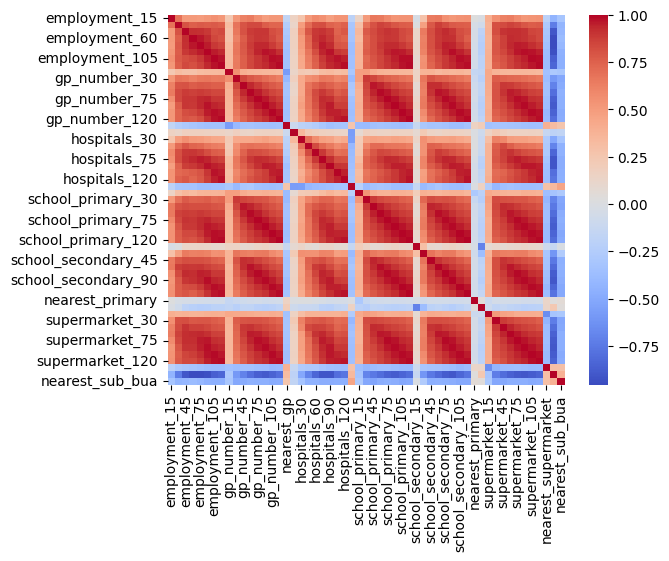

In [36]:
corr = pt_gm.select_dtypes('number').drop(['Shape_Leng', 'Shape_Area'],axis=1).corr()

sns.heatmap(corr,cmap=sns.color_palette("coolwarm", as_cmap=True))

In [39]:
# Fit to data and predict using pipelined scaling, GNB and PCA
std_pca = make_pipeline(StandardScaler(), PCA(n_components=2))
pt_pca = std_pca.fit_transform(pt_gm.select_dtypes('number').drop(['Shape_Leng', 'Shape_Area'],axis=1))

In [40]:
pt_pca.shape

(1673, 2)

In [41]:
total_var = std_pca[1].explained_variance_ratio_.sum() * 100

In [47]:
std_pca[1].explained_variance_ratio_

array([0.68545938, 0.0491664 ])

In [45]:
total_var

np.float64(73.46257727285371)

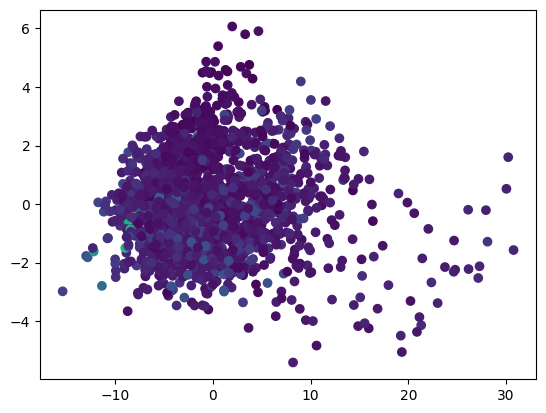

In [44]:
plt.scatter(pt_pca[:,0],pt_pca[:,1],c=pt_gm_price['price'])

In [45]:
# save pca to df
pca_df = pd.DataFrame(pt_pca)
pca_df['lsoa11'] = pt_gm.reset_index()['geo_code'].copy()

In [46]:
pca_df = pca_df.rename(columns={0:'accessibility_PCA1',1:'accessibility_PCA2'})

### School quality

In [47]:
# 8. School quality
school_quality = pd.read_csv('data/01_raw/School_quality/State_funded_schools_inspections_and_outcomes_as_at_31_August_2024.csv',encoding='ISO-8859-1')

C:\Users\2702471O\AppData\Local\Temp\ipykernel_96876\955227219.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  school_quality = pd.read_csv('data/01_raw/School_quality/State_funded_schools_inspections_and_outcomes_as_at_31_August_2024.csv',encoding='ISO-8859-1')


In [48]:
# select GM local authorities
school_quality = school_quality[school_quality['Local authority'].isin(['Bolton','Bury', 'Manchester', 'Oldham', 'Rochdale', 'Salford', 'Stockport', 'Tameside', 'Trafford', 'Wigan'])]

In [49]:
# postcode to lat lon
postcode = pd.read_csv('data/01_raw/postcode_latlon/ukpostcodes.csv',encoding='ISO-8859-1')

In [50]:
# link school to lat lon
school_quality = school_quality.join(postcode.set_index('postcode'),on='Postcode',how='left')

In [51]:
school_quality['id'].isna().sum()

np.int64(1)

In [52]:
school_quality.loc[school_quality['id'].isnull()==1,'latitude'] = 53.54294
school_quality.loc[school_quality['id'].isnull()==1,'longitude'] = -2.128622

In [53]:
# only keep school overall effectiveness, lat, lon, URN, school name, ofsted phase, local authority
school_quality = school_quality[['URN','School name','Ofsted phase','Type of education','Local authority','Overall effectiveness','Postcode','latitude','longitude']]

In [54]:
school_quality_pri_sec = school_quality[school_quality['Ofsted phase'].isin(['Primary','Secondary'])]

In [55]:
# save a copy for geospatial exploration
school_quality.to_csv('data/02_intermediate/state_school_GM.csv')

In [56]:
school_quality_pri_sec.to_csv('data/02_intermediate/state_primary_secondary_school_GM.csv')

## 4.2 Link data

### Visualise neighbourhood data

In [57]:
# Rename lsoa column name for all data to merge
pop_den_lsoa = pop_den_lsoa.rename(columns={'LSOA Code':'lsoa11','Mid-2020 population':'population_2020','Area Sq Km':'lsoa_area','People per Sq Km':'pop_den_2020'})
imd_score = imd_score.rename(columns={'LSOA code (2011)':'lsoa11','Income Score (rate)':'income_score'})

In [58]:
# save neighbourhood data for visualisation
neighs_data = [imd_score[['lsoa11','income_score']],pca_df,pop_den_lsoa[['lsoa11','population_2020','lsoa_area','pop_den_2020']]]
neighs_df = ft.reduce(lambda left, right: pd.merge(left, right, on=['lsoa11'],how='inner'), neighs_data)

In [59]:
gm = gpd.read_file('data/01_raw/Shapefile/GM_lsoa.shp')

In [60]:
gm = gm.join(neighs_df.set_index('lsoa11'),on='code',how='left')

In [61]:
gm.columns

Index(['code', 'name', 'label', 'LA', 'Shape_Leng', 'Shape_Area', 'geometry',
       'income_score', 'accessibility_PCA1', 'accessibility_PCA2',
       'population_2020', 'lsoa_area', 'pop_den_2020'],
      dtype='object')

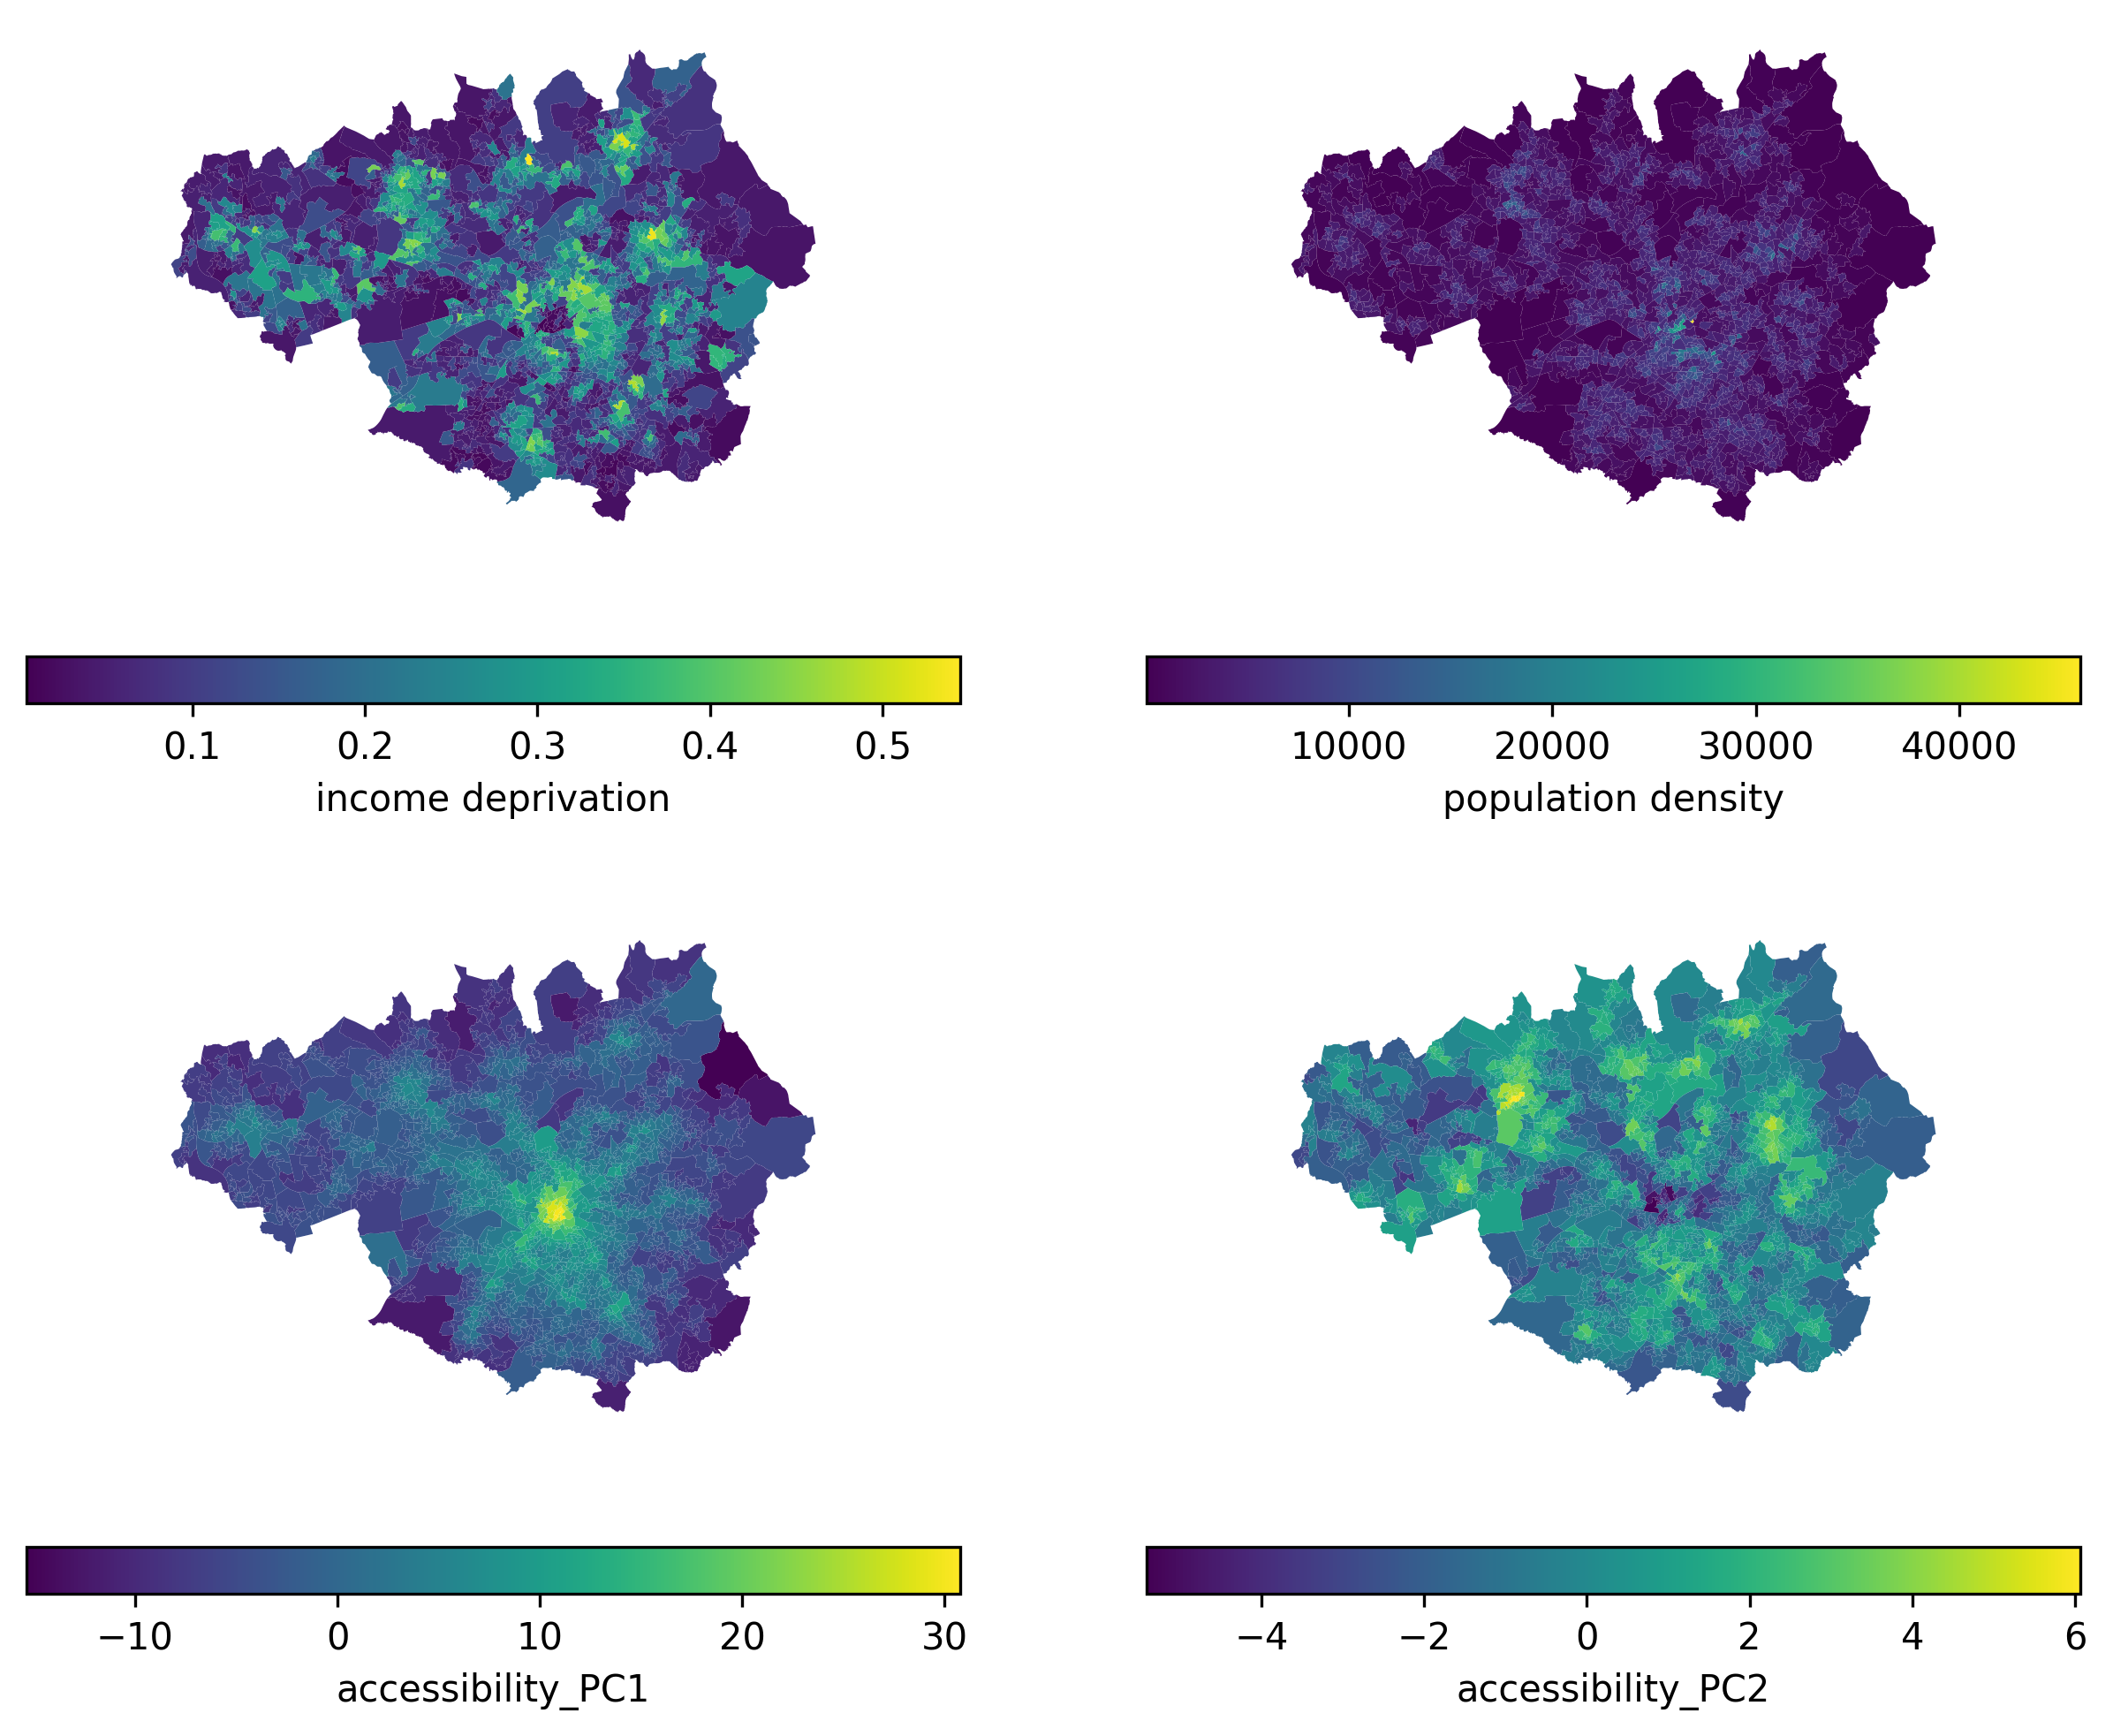

In [62]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,8),dpi=300)
gm.plot(column='income_score',ax=ax1,legend=True,
    legend_kwds={"label": "income deprivation", "orientation": "horizontal"})
ax1.set_axis_off()

gm.plot(column='pop_den_2020',ax=ax2,legend=True,
    legend_kwds={"label": "population density", "orientation": "horizontal"})
ax2.set_axis_off()

gm.plot(column='accessibility_PCA1',ax=ax3,legend=True,
    legend_kwds={"label": "accessibility_PC1", "orientation": "horizontal"})
ax3.set_axis_off()

gm.plot(column='accessibility_PCA2',ax=ax4,legend=True,
    legend_kwds={"label": "accessibility_PC2", "orientation": "horizontal"})
ax4.set_axis_off()

### Neighbourhood data

In [63]:
# merge neighbor data to listing
dfs_merge = [listing_epc_val_dedu,imd_score[['lsoa11','income_score']],pca_df,pop_den_lsoa[['lsoa11','population_2020','lsoa_area','pop_den_2020']]]
listing_epc_val_dedu_nei = ft.reduce(lambda left, right: pd.merge(left, right, on=['lsoa11'],how='left'), dfs_merge)

In [64]:
listing_epc_val_dedu_nei[['accessibility_PCA1','accessibility_PCA2','population_2020','lsoa_area','pop_den_2020','income_score']].isna().sum()

accessibility_PCA1    0
accessibility_PCA2    0
population_2020       0
lsoa_area             0
pop_den_2020          0
income_score          0
dtype: int64

### PCA and house price

In [65]:
listing_epc_val_dedu_nei['logprice'] = np.log(listing_epc_val_dedu_nei['price'])

In [66]:
corr = listing_epc_val_dedu_nei[['logprice','accessibility_PCA1','accessibility_PCA2']].corr()

In [67]:
corr

,logprice,accessibility_PCA1,accessibility_PCA2
logprice,1.000000,-0.040249,-0.150592
accessibility_PCA1,-0.040249,1.000000,-0.104357
accessibility_PCA2,-0.150592,-0.104357,1.000000


### Location data

In [68]:
# Lon, lat, x, y
listing_epc_val_dedu_nei_loc = listing_epc_val_dedu_nei.join(uprn.set_index('UPRN'),on='uprn',how='left')

In [69]:
listing_epc_val_dedu_nei_loc[['LATITUDE','LONGITUDE','X_COORDINATE','Y_COORDINATE']].isna().sum()

LATITUDE        4
LONGITUDE       4
X_COORDINATE    4
Y_COORDINATE    4
dtype: int64

In [70]:
# drop na
listing_epc_val_dedu_nei_loc = listing_epc_val_dedu_nei_loc.dropna(subset=["LATITUDE", "LONGITUDE"]).copy()

### School quality

In [71]:
listing_school = listing_epc_val_dedu_nei_loc.copy()

In [72]:
# drop school without rating
school_quality_pri_sec = school_quality_pri_sec.dropna(subset=['Overall effectiveness'])

In [73]:
df_la = []
for la in listing_school['nspl_local_authority'].unique():
    house = listing_school[listing_school['nspl_local_authority']==la].reset_index()
    primary = school_quality_pri_sec[(school_quality_pri_sec['Ofsted phase']=='Primary') & (school_quality_pri_sec['Local authority']==la)]
    secondary = school_quality_pri_sec[(school_quality_pri_sec['Ofsted phase']=='Secondary') & (school_quality_pri_sec['Local authority']==la)]

    # Calculate distances between each house and the primary/secondary schools
    primary_distances = cdist(house[['LATITUDE', 'LONGITUDE']].values, primary[['latitude', 'longitude']].values)
    secondary_distances = cdist(house[['LATITUDE', 'LONGITUDE']].values, secondary[['latitude', 'longitude']].values)

    # school with minimum distane
    pri_min_idx = primary_distances.argmin(axis=1)
    sec_min_idx = secondary_distances.argmin(axis=1)

    # join with listing df
    house_pri = house.join(pd.DataFrame(pri_min_idx,columns=['primary_nearest_idx']), how='left')
    house_pri = house_pri.join(primary.reset_index()[['URN','Overall effectiveness']],on='primary_nearest_idx',how='left')

    house_pri_sec = house_pri.join(pd.DataFrame(sec_min_idx,columns=['secondary_nearest_idx']), how='left')
    house_pri_sec = house_pri_sec.join(secondary.reset_index()[['URN','Overall effectiveness']],on='secondary_nearest_idx',how='left',lsuffix='primary',rsuffix='secondary')

    print('{} primary nan: {},secondary nan: {}'.format(la,house_pri_sec['Overall effectivenessprimary'].isna().sum(),house_pri_sec['Overall effectivenesssecondary'].isna().sum()))
    # print('{}: , Max primary school idx: {}, max idx in joined listing: {}'.format(la,primary.reset_index().index.max(),pri_min_idx.max()))
    # print('{}: , Max secondary school idx: {}, max idx in joined listing: {}'.format(la,secondary.reset_index().index.max(),sec_min_idx.max()))
    df_la.append(house_pri_sec)

Bury primary nan: 0,secondary nan: 0
Stockport primary nan: 0,secondary nan: 0
Manchester primary nan: 0,secondary nan: 0
Trafford primary nan: 0,secondary nan: 0
Rochdale primary nan: 0,secondary nan: 0
Bolton primary nan: 0,secondary nan: 0
Oldham primary nan: 0,secondary nan: 0
Salford primary nan: 0,secondary nan: 0
Wigan primary nan: 0,secondary nan: 0
Tameside primary nan: 0,secondary nan: 0


In [75]:
listing_epc_val_dedu_nei_loc_sch = pd.concat(df_la)

In [79]:
listing_epc_val_dedu_nei_loc_sch['Overall effectivenessprimary'] = listing_epc_val_dedu_nei_loc_sch['Overall effectivenessprimary'].map({1:4,2:3,3:2,4:1})
listing_epc_val_dedu_nei_loc_sch['Overall effectivenesssecondary'] = listing_epc_val_dedu_nei_loc_sch['Overall effectivenesssecondary'].map({1:4,2:3,3:2,4:1})

# 5. Save data

In [81]:
listing_epc_neighbourhood = listing_epc_val_dedu_nei_loc_sch.copy()

In [82]:
listing_epc_neighbourhood.shape

(216597, 163)

In [83]:
listing_epc_neighbourhood.to_csv('data/03_linked/enriched_listing.csv', chunksize=10000)